# Main breakthroughs in Word embeddings, from Word Counts to LLMs:

# Low-tech beginnings:


* **Word Counts:** Basic frequency of words in a corpus served as initial representations. Useful for simple tasks but ignored semantic relationships.
* **Term Frequency (TF):** simply counting the occurrences of words within a corpus was one of the earliest methods for representing words. This basic approach laid the foundation for more sophisticated techniques.
* **N-grams:** These are sequences of n consecutive words (e.g., bigrams for pairs, trigrams for triplets). By analyzing n-gram frequencies, we can capture some local context and word relationships, going beyond individual word counts.

**Import Libraries**

In [1]:
import pandas as pd
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist, MLEProbDist
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import keras
from scipy.sparse.linalg import svds
from sklearn.decomposition import TruncatedSVD

**Define sample documents list**

In [2]:
Doc_1= "The cat in the hat"
Doc_2= "The quick brown fox"
Doc_3= "The hat is blue"

Docs =[Doc_1,Doc_2,Doc_3]

> <h2>Term Frequency (TF)</h2>
> <li>TF(t,d) is the term frequency of term t in document d (how often the term appears in the document).</li>
> <li>TF(t,d) is the term frequency of term t in document d (how often the term appears in the document).</li>

In [3]:
#get distinct words for each document
lst = []
for d in Docs:
    lst.extend(d.lower().split(' '))
wrds = set(lst) # remove duplicate words
wrds

{'blue', 'brown', 'cat', 'fox', 'hat', 'in', 'is', 'quick', 'the'}

In [4]:
#form a dataframe to represent TF for each word in each Document where columns are words and rows are documents
def count_wrd_Doc(wrd,doc):
    i=0
    for w in doc.lower().split(' '):
        if wrd == w:
            i = i+1
    return i/len(doc.lower().split(' '))
    
tf_df = pd.DataFrame(columns=list(wrds)) #empty dataframe initialized with words column headers
freq_lst=[] #empty list for each column to save word frequencies in each document
for c in tf_df.columns:
    freq_lst=[]#empty the list
    for d in Docs:
        freq_lst.append(count_wrd_Doc(c,d))#append the frequency of word in document d
    tf_df[c]=freq_lst #assign values to column
tf_df #display the dataframe of TF for each word in each document

,in,blue,quick,the,brown,hat,cat,fox,is
0,0.2,0.00,0.00,0.40,0.00,0.20,0.2,0.00,0.00
1,0.0,0.00,0.25,0.25,0.25,0.00,0.0,0.25,0.00
2,0.0,0.25,0.00,0.25,0.00,0.25,0.0,0.00,0.25


**Document Frequency (DF)**
* **Calculate Document Frequency (DF): the word appears in how many documents*** **Calculate Document Frequency (DF): the word appears in how many documents**

In [5]:
df_df = pd.DataFrame(columns=list(wrds)) #empty dataframe initialized with words column headers
for c in df_df.columns:
    df_df[c] = [sum(1 for doc in Docs if c in doc.lower().split(' '))]
df_df #display the dataframe of DF for each word 

,in,blue,quick,the,brown,hat,cat,fox,is
0,1,1,1,3,1,2,1,1,1


**Inverse Document Frequency (IDF)**
* **IDF(t,D) is the inverse document frequency of term t in the entire document set D (logarithmically scaled inverse fraction of the documents that contain the term).*** **IDF(t,D) is the inverse document frequency of term t in the entire document set D (logarithmically scaled inverse fraction of the documents that contain the term).**

In [6]:
idf_df = pd.DataFrame(columns=list(wrds)) #empty dataframe initialized with words column headers
for c in idf_df.columns:
    N = 3 #No of documents
    df = df_df[c].iloc[0] # DF of word
    idf_df[c] = [math.log((N+1) / (df+1))+1]#IDF = log (no. of documents/DF(word)) 
idf_df #display the dataframe of idf for each word 

,in,blue,quick,the,brown,hat,cat,fox,is
0,1.693147,1.693147,1.693147,1.0,1.693147,1.287682,1.693147,1.693147,1.693147


**Term Frequency - Inverse Document Frequency (TF-IDF)= TF * IDF**

In [7]:
tfidf_df = pd.DataFrame(columns=list(wrds)) #empty dataframe initialized with words column headers
tfidf_lst=[]  #empty list for each column 
for c in tfidf_df.columns:
    tfidf_lst=[] #empty list for each column
    for i in range(0,len(Docs)):
        tf_idf_d1 = tf_df[c].iloc[i]*idf_df[c].iloc[0] #append tf of word in i th document to idf of word
        tfidf_lst.append(tf_idf_d1)
    tfidf_df[c]=tfidf_lst#assign tfidf values for each word
tfidf_df #display the dataframe of tf-idf for all words

,in,blue,quick,the,brown,hat,cat,fox,is
0,0.338629,0.000000,0.000000,0.40,0.000000,0.257536,0.338629,0.000000,0.000000
1,0.000000,0.000000,0.423287,0.25,0.423287,0.000000,0.000000,0.423287,0.000000
2,0.000000,0.423287,0.000000,0.25,0.000000,0.321921,0.000000,0.000000,0.423287


**L2 Normalization**
* **L2 normalization, also known as Euclidean normalization or L2 norm normalization, is a technique used to scale vectors (or arrays) in such a way that their Euclidean norm becomes equal to 1.**

In [8]:
normalized_df = pd.DataFrame(columns=tfidf_df.columns)

# Apply L2 normalization to each document's TF-IDF values
for i,row in enumerate(tfidf_df.iterrows()):
    # Extract TF-IDF values    
    tfidf_values_list = list(tfidf_df.iloc[i].values)
    # Calculate L2 norm
    l2_norm = math.sqrt(sum(val**2 for val in tfidf_values_list))
    # Normalize TF-IDF values using L2 norm
    normalized_tfidf = [val / l2_norm for val in list(tfidf_df.iloc[i].values)]
    new_row = pd.Series(normalized_tfidf, index=tfidf_df.columns)
    normalized_df.loc[len(normalized_df)] = new_row
    
normalized_df

,in,blue,quick,the,brown,hat,cat,fox,is
0,0.501651,0.000000,0.000000,0.592567,0.000000,0.381519,0.501651,0.000000,0.000000
1,0.000000,0.000000,0.546454,0.322745,0.546454,0.000000,0.000000,0.546454,0.000000
2,0.000000,0.584483,0.000000,0.345205,0.000000,0.444514,0.000000,0.000000,0.584483


**TfidfVectorizer Python Library**

In [9]:
# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(norm='l2',smooth_idf=True)

# Fit the documents and transform them into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(Docs)

# Get the feature names (terms) from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

df_tfidf = pd.DataFrame(data=tfidf_matrix.toarray(), columns=feature_names)
df_tfidf

,blue,brown,cat,fox,hat,in,is,quick,the
0,0.000000,0.000000,0.501651,0.000000,0.381519,0.501651,0.000000,0.000000,0.592567
1,0.000000,0.546454,0.000000,0.546454,0.000000,0.000000,0.000000,0.546454,0.322745
2,0.584483,0.000000,0.000000,0.000000,0.444514,0.000000,0.584483,0.000000,0.345205


* **The TfidfVectorizer in scikit-learn, by default, adds a smoothing term to the denominator of the IDF calculation to avoid division by zero. This is done to handle the case where a term is present in all documents, ensuring that the IDF is not undefined.**
* **L2 normalization, also known as Euclidean normalization or L2 norm normalization, is a technique used to scale vectors (or arrays) in such a way that their Euclidean norm becomes equal to 1.**

> <h2>Unigram</h2>
> <li>A unigram, in the context of natural language processing (NLP) and linguistics, refers to a single unit or token of a word. It is the simplest form of linguistic analysis where text is broken down into individual words. In other words, a unigram is a term used to describe a single word in a sequence of words.</li>
> <li>Unigrams are the building blocks for more complex linguistic analyses, such as bigrams (pairs of consecutive words), trigrams (triplets of consecutive words), and n-grams in general.</li>

In [10]:
#Probability of unigram P(w)=C(w)/m same idea of TF
def count_wrd_Doc(wrd,doc):
    i=0
    for w in doc.lower().split(' '):
        if wrd == w:
            i = i+1
    return i
    
unigram_df = pd.DataFrame(columns=list(wrds)) #empty dataframe initialized with words column headers
freq_lst=[] #empty list for each column to save word frequencies in each document
for c in tf_df.columns:
    freq_lst=[]#empty the list
    for d in Docs:
        freq_lst.append(count_wrd_Doc(c,d))#append the frequency of word in document d
    unigram_df[c]=freq_lst #assign values to column
unigram_df #display the dataframe of TF for each word in each document

,in,blue,quick,the,brown,hat,cat,fox,is
0,1,0,0,2,0,1,1,0,0
1,0,0,1,1,1,0,0,1,0
2,0,1,0,1,0,1,0,0,1


**Unigrams python function**

In [11]:
for d in Docs:
    words = word_tokenize(d.lower())
    result = list(ngrams(words, 1))
    # Calculate frequency distribution of bigrams
    ngram_freq = FreqDist(result)
    for word, frequency in ngram_freq.items():
        print(f"{word}: {frequency}")

('the',): 2
('cat',): 1
('in',): 1
('hat',): 1
('the',): 1
('quick',): 1
('brown',): 1
('fox',): 1
('the',): 1
('hat',): 1
('is',): 1
('blue',): 1


**Bigram**
* **A bigram, in the context of natural language processing (NLP) and linguistics, refers to an ordered pair of consecutive words within a text or sequence of words. It is a type of n-gram, where "n" represents the number of words in the sequence.*** **A bigram, in the context of natural language processing (NLP) and linguistics, refers to an ordered pair of consecutive words within a text or sequence of words. It is a type of n-gram, where "n" represents the number of words in the sequence.**

In [12]:
#get bi-grams of input sentence
def bi_lst(doc):
    wrds = doc.lower().split(' ')
    bi_lst = []
    for j in range(0,len(wrds)-1):
        bi_lst.append(wrds[j:j+2])
    return bi_lst

lst = []
for d in Docs:
    lst.extend(bi_lst(d))
unique_list = []
unique_list = [item for item in lst if item not in unique_list]

def count_biwrd_Doc(st,doc):
    i=0    
    for s in bi_lst(doc):
        if s == st.split(' '):
            i = i+1
    return i
bigram_df = pd.DataFrame(columns=list((' '.join(x) for x in unique_list))) #empty dataframe initialized with words column headers
freq_lst=[] #empty list for each column to save word frequencies in each document
for c in bigram_df.columns:
    freq_lst=[]#empty the list
    for d in Docs:
        freq_lst.append(count_biwrd_Doc(c,d))#append the frequency of word in document d
    bigram_df[c]=freq_lst #assign values to column
bigram_df #display the dataframe of TF for each word in each document

,the cat,cat in,in the,the hat,the quick,quick brown,brown fox,the hat,hat is,is blue
0,1,1,1,1,0,0,0,1,0,0
1,0,0,0,0,1,1,1,0,0,0
2,0,0,0,1,0,0,0,1,1,1


**Bigrams python function**

In [13]:
for d in Docs:
    words = word_tokenize(d.lower())
    result = list(ngrams(words, 2))
    # Calculate frequency distribution of bigrams
    ngram_freq = FreqDist(result)
    for word, frequency in ngram_freq.items():
        print(f"{word}: {frequency}")

('the', 'cat'): 1
('cat', 'in'): 1
('in', 'the'): 1
('the', 'hat'): 1
('the', 'quick'): 1
('quick', 'brown'): 1
('brown', 'fox'): 1
('the', 'hat'): 1
('hat', 'is'): 1
('is', 'blue'): 1


# Distributional Semantics:

* **Word2Vec (2013):** First major breakthrough. Learned word embeddings by predicting surrounding words, capturing semantic similarities.
* **GloVe (2014):** Leverages co-occurrence statistics for better context sensitivity.
* **FastText (2016):** Incorporates subword information, handling rare words and morphological variants.

> <h2>Skip-gram & Continuous Bag of Words (CBOW)</h2>
> These models use shallow neural networks to learn word embeddings. Skip-gram predicts context words given a target word, while CBOW predicts a target word given its context. These models use shallow neural networks to learn word embeddings. Skip-gram predicts context words given a target word, while CBOW predicts a target word given its context. 

**CBOW**
* Objective: The main objective of CBOW is to predict a target word given its context (surrounding words). It learns to represent words in a continuous vector space based on their distributional semantics.
* Architecture: CBOW uses a neural network with a single hidden layer. The input layer and output layer are typically equal to the size of the vocabulary, and the hidden layer has a much smaller dimension, often referred to as the embedding dimension.
* Input and Output: The input to the CBOW model is a set of context words represented as one-hot vectors (binary vectors with a 1 at the index corresponding to the word's position in the vocabulary). The output is the target word's one-hot vector.
* Context Window: The context window is a fixed-size window of surrounding words used to predict the target word. The model is trained to predict the target word based on the words within this context window.

In [14]:
def count_wrd_Doc(wrd,doc):
    i=0
    for w in doc.lower().split(' '):
        if wrd == w:
            i = i+1
    return i
    
cw_df = pd.DataFrame(columns=list(wrds)) #empty dataframe initialized with words column headers
freq_lst=[] #empty list for each column to save word frequencies in each document
for c in tf_df.columns:
    freq_lst=[]#empty the list
    for d in Docs:
        freq_lst.append(count_wrd_Doc(c,d))#append the frequency of word in document d
    cw_df[c]=freq_lst #assign values to column
cw_df #display the datafram

,in,blue,quick,the,brown,hat,cat,fox,is
0,1,0,0,2,0,1,1,0,0
1,0,0,1,1,1,0,0,1,0
2,0,1,0,1,0,1,0,0,1


In [15]:
# Create a CountVectorizer instance
vectorizer = CountVectorizer()

# Fit and transform the documents to create the Bag of Words representation
X_bow = vectorizer.fit_transform(Docs)
feature_names = vectorizer.get_feature_names_out()
# Print the Bag of Words representation
print("Bag of Words representation:")
print(X_bow.toarray())
print("Feature names:")
print(feature_names)

Bag of Words representation:
[[0 0 1 0 1 1 0 0 2]
 [0 1 0 1 0 0 0 1 1]
 [1 0 0 0 1 0 1 0 1]]
Feature names:
['blue' 'brown' 'cat' 'fox' 'hat' 'in' 'is' 'quick' 'the']


**Skip-Grams**
* **Objective:** The main objective of the Skip-gram model is to learn distributed representations (word embeddings) of words in a continuous vector space. It does so by predicting the context words based on a given target word.
* **Architecture:** Skip-gram uses a neural network with a single hidden layer. The input layer and output layer are typically equal to the size of the vocabulary, and the hidden layer has a much smaller dimension, often referred to as the embedding dimension.
* **Input and Output:** The input to the Skip-gram model is a one-hot vector representing a target word (the word for which embeddings are being learned). The output is a probability distribution over the vocabulary, representing the likelihood of each word being a context word.
* **Context Window:** During training, a context window is defined around the target word. The context words within this window are used to predict the target word. The context window provides local context information for each target word.
* **Training Objective:** Skip-gram is trained using a supervised learning approach. The model aims to minimize the cross-entropy loss between the predicted probability distribution over the vocabulary and the actual distribution (one-hot vector of the true context word).

In [16]:
# Generate training pairs (target word, context word)
window_size = 3# the window specifies the context words size neigbored the target word 
training_pairs = []
context_words = []#the context words for w=3 i-3,i-2,i-1,i+1,i+2,i+3
for d in Docs:
    t=[]
    c=[]
    for i, target_word in enumerate(d.lower().split(' ')):
        start = max(0, i - window_size)
        end = min(len(d.lower().split(' ')), i + window_size + 1)
        c = [d.lower().split(' ')[j] for j in range(start, end) if j != i]
        for context_word in c:
            t.append((target_word, context_word))
        print("document:",d.lower())
        print("target:",target_word)
        print("context words",c,",window_size",window_size)
        print("----------------------------------------")
    training_pairs.append(t)    

document: the cat in the hat
target: the
context words ['cat', 'in', 'the'] ,window_size 3
----------------------------------------
document: the cat in the hat
target: cat
context words ['the', 'in', 'the', 'hat'] ,window_size 3
----------------------------------------
document: the cat in the hat
target: in
context words ['the', 'cat', 'the', 'hat'] ,window_size 3
----------------------------------------
document: the cat in the hat
target: the
context words ['the', 'cat', 'in', 'hat'] ,window_size 3
----------------------------------------
document: the cat in the hat
target: hat
context words ['cat', 'in', 'the'] ,window_size 3
----------------------------------------
document: the quick brown fox
target: the
context words ['quick', 'brown', 'fox'] ,window_size 3
----------------------------------------
document: the quick brown fox
target: quick
context words ['the', 'brown', 'fox'] ,window_size 3
----------------------------------------
document: the quick brown fox
target: brown

In [17]:
training_pairs # this is the pairs of training formed the target and context word pairs according to context window size

[[('the', 'cat'),
  ('the', 'in'),
  ('the', 'the'),
  ('cat', 'the'),
  ('cat', 'in'),
  ('cat', 'the'),
  ('cat', 'hat'),
  ('in', 'the'),
  ('in', 'cat'),
  ('in', 'the'),
  ('in', 'hat'),
  ('the', 'the'),
  ('the', 'cat'),
  ('the', 'in'),
  ('the', 'hat'),
  ('hat', 'cat'),
  ('hat', 'in'),
  ('hat', 'the')],
 [('the', 'quick'),
  ('the', 'brown'),
  ('the', 'fox'),
  ('quick', 'the'),
  ('quick', 'brown'),
  ('quick', 'fox'),
  ('brown', 'the'),
  ('brown', 'quick'),
  ('brown', 'fox'),
  ('fox', 'the'),
  ('fox', 'quick'),
  ('fox', 'brown')],
 [('the', 'hat'),
  ('the', 'is'),
  ('the', 'blue'),
  ('hat', 'the'),
  ('hat', 'is'),
  ('hat', 'blue'),
  ('is', 'the'),
  ('is', 'hat'),
  ('is', 'blue'),
  ('blue', 'the'),
  ('blue', 'hat'),
  ('blue', 'is')]]

In [18]:
# Initialize word vectors randomly
embedding_dim = 10
learning_rate = 0.01
epochs = 500
word_vectors = []
vocab=[]
for d in Docs:
    vocab.append((list(set(d.lower().split(' ')))))
for v in vocab:
    word_vectors.append({word: np.random.rand(embedding_dim) for word in v})#initialize random values vector for each word 
    
for i in range(0,len(training_pairs)):
    # Train the Skip-gram model
    for epoch in range(epochs):
    
        for target_word, context_word in training_pairs[i]:
            # Forward pass
            input_vector = word_vectors[i][target_word]
            output_vector = word_vectors[i][context_word]

            # Calculate loss (using negative log likelihood)
            error = -np.log(np.exp(np.dot(input_vector, output_vector)))

            # Backward pass (update word vectors using gradient descent)
            gradient = input_vector * np.exp(np.dot(input_vector, output_vector)) / (1 + np.exp(np.dot(input_vector, output_vector)))
            word_vectors[i][target_word] -= learning_rate * gradient
            word_vectors[i][context_word] -= learning_rate * gradient

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {error}")
    print('-------------------------------')
    #word vectors
    for word, vector in word_vectors[i].items():
        print(f"Vector for '{word}': {vector}")
    print('-------------------------------')

Epoch 0, Loss: -1.5093496873972827
-------------------------------
Vector for 'hat': [ 1.26396494e-03  7.55756571e-04  6.15230115e-04 -3.62474712e-04
  6.40043666e-04  7.35821253e-05 -2.12045798e-04 -1.16750239e-04
  1.23862735e-03 -1.07468203e-03]
Vector for 'the': [ 1.34378773e-04  8.11035524e-05  5.06106915e-05 -5.46979171e-05
  6.69447643e-05 -5.05075857e-07 -3.28340503e-05 -2.73513008e-05
  1.29392856e-04 -1.35044867e-04]
Vector for 'in': [-5.66244324e-04 -2.87072182e-04 -3.03318178e-04  2.94322707e-04
 -3.96275716e-04 -1.63638584e-05  1.13746836e-04 -1.59205284e-06
 -5.10034946e-04  6.03276122e-04]
Vector for 'cat': [-5.48615637e-04 -3.81857755e-04 -2.00589540e-04  6.65760006e-05
 -1.64629147e-04 -2.69570012e-05  9.99633750e-05  1.43866967e-04
 -5.76818002e-04  3.97942766e-04]
-------------------------------
Epoch 0, Loss: -2.9235076323366913
-------------------------------
Vector for 'quick': [ 2.54774515e-03  8.37444875e-04 -3.13200831e-04  4.28503107e-05
  1.02851564e-03  1.31

> <h2>TensorFlow Skip-gram</h2>
The TensorFlow implementation of the Skip-gram model involves constructing a neural network with an input layer, a hidden layer (embedding layer), and an output layer. Using TensorFlow's high-level API, we define the model architecture and specify the training process. First, we prepare the training data by extracting target-context word pairs from the corpus. Then, we build the Skip-gram model architecture, with the input layer representing target words and the output layer predicting context words. During training, we optimize the model parameters to minimize prediction errors using techniques. Once trained, we can evaluate the model's performance on a validation dataset and extract word embeddings from the trained model. These embeddings capture semantic relationships between words and can be used for various downstream natural language processing tasks.

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dot, Dense,Flatten
from tensorflow.keras.models import Model
from nltk.tokenize import word_tokenize

# Create a vocabulary with unique words and indices
vocab = []
for doc in Docs:
    wrds=list(set(doc.lower().split()))
    vocab.append({w:wrds.index(w) for w in wrds})
reverse_vocab = []
for v in vocab:
    reverse_vocab.append({idx: word for word, idx in v.items()})

# Generate training pairs (target word, context word)
training=[]
for d,v in zip(Docs,vocab):
    training_pairs=[]
    for i, target_word in enumerate(d.lower().split(' ')):
        start = max(0, i - window_size)
        end = min(len(d.lower().split(' ')), i + window_size + 1)
        context_words = [d.lower().split(' ')[j] for j in range(start, end) if j != i]
        for context_word in context_words:
            training_pairs.append((v[target_word], v[context_word]))
    training.append(training_pairs)
    
    
# Define the Skip-gram model using TensorFlow
for i,v,t_p in zip(range(0,len(Docs)),vocab,training):
    target_word_input = tf.keras.layers.Input(shape=(1,), name="target_word")
    context_word_input = tf.keras.layers.Input(shape=(1,), name="context_word")

    embedding_layer = Embedding(input_dim=len(v), output_dim=embedding_dim)
    target_word_embedding = embedding_layer(target_word_input)#obtain respective embeddings
    context_word_embedding = embedding_layer(context_word_input)#obtain respective embeddings
    dot_product = Dot(axes=1, normalize=False)([target_word_embedding, context_word_embedding])#captures relations and similarity between context and target words
    #dot_product = Dot(axes=2)([target_word_embedding, context_word_embedding])
    output_layer = Dense(1, activation='sigmoid')(Flatten()(dot_product))  # Flatten the output

    model = Model(inputs=[target_word_input, context_word_input], outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    
    # Train the Skip-gram model
    target_words = np.array([pair[0] for pair in t_p], dtype=np.int32)
    context_words = np.array([pair[1] for pair in t_p], dtype=np.int32)

    labels = np.array([1] * len(t_p), dtype=np.float32)# Positive labels for all training pairs
    
    model.fit({'target_word': target_words, 'context_word': context_words}, labels, epochs=500,verbose=0)

    # Access word vectors
    word_vectors = embedding_layer.get_weights()[0]
    for idx, word in reverse_vocab[i].items():
        print(f"Vector for '{word}': {word_vectors[idx]}")
        print("-----------------------------------------------------------")

Vector for 'hat': [ 0.41776547  0.34664506 -0.3207288   0.4104711  -0.3791212  -0.38992032
 -0.34966627 -0.3585837   0.44517478  0.39688775]
-----------------------------------------------------------
Vector for 'the': [ 0.37037614  0.38806823 -0.34553996  0.35983267 -0.398894   -0.40422946
 -0.36169043 -0.4040607   0.4277574   0.41149908]
-----------------------------------------------------------
Vector for 'in': [ 0.32604927  0.38850224 -0.395227    0.3643465  -0.3766033  -0.44842288
 -0.3851582  -0.4091429   0.24182676  0.39738524]
-----------------------------------------------------------
Vector for 'cat': [ 0.39470968  0.4049861  -0.40584922  0.42190322 -0.37070686 -0.42419386
 -0.36604992 -0.3418594   0.20109762  0.3474234 ]
-----------------------------------------------------------
Vector for 'quick': [-0.38505092 -0.38257995 -0.38252965  0.38925633 -0.38941628 -0.33871493
  0.3548371   0.34554076  0.4337702   0.30993906]
------------------------------------------------------

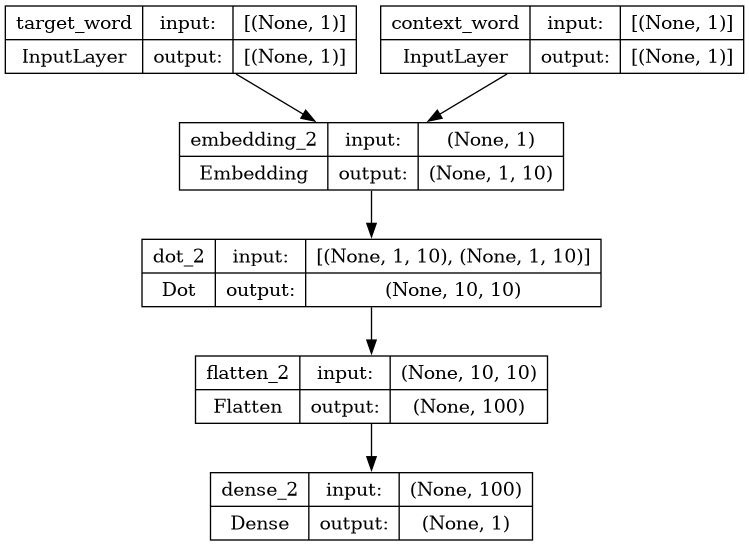

In [20]:
keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

> <h2>Latent Semantic Analysis (LSA)</h2>

LSA Main Components:
* **Term-Document Matrix:** LSA starts with the creation of a term-document matrix, where each row corresponds to a term (word) and each column corresponds to a document. The entries in the matrix represent the frequency of each term in each document.
* **Singular Value Decomposition (SVD):** SVD is a linear algebra technique used to factorize a matrix into three matrices: U, Σ (Sigma), and V^T (the transpose of V). In the context of LSA: U: Document-topic matrix (describes relationships between documents and topics), Σ (Sigma): Diagonal matrix containing singular values (describes the importance of each topic), & V^T: Term-topic matrix (describes relationships between terms and topics).
* **Dimensionality Reduction:** LSA typically involves reducing the dimensionality of the term-document matrix by retaining only the top singular values and corresponding columns in U, Σ, and V^T. This reduction helps capture the most significant semantic information while discarding noise and redundancy.
* **Semantic Space:** The reduced matrices U and V^T define a lower-dimensional semantic space where terms and documents are represented. Each document and term are mapped into this space, and their proximity in the space reflects semantic similarity.
* **Topic Modeling:** The columns of the U and V^T matrices represent topics in the semantic space. Documents and terms are associated with a linear combination of these topics. Topics capture the underlying themes or concepts in the corpus.

In [21]:
from sklearn.preprocessing import normalize

#Generate a document-term matrix of shape m x n having TF-IDF scores.
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(Docs)

# Convert the term-document matrix to a dense NumPy array
term_document_matrix = X.toarray()

# Normalize the term-document matrix
normalized_term_document_matrix = normalize(term_document_matrix, norm='l2', axis=1)

# Apply Latent Semantic Analysis (LSA) using Truncated SVD
def lsa(matrix, num_topics):
    # Perform Truncated SVD
    U, Sigma, Vt = np.linalg.svd(matrix, full_matrices=False)
    
    # Retain only the top 'num_topics' components
    U = U[:, :num_topics]
    Sigma = np.diag(Sigma[:num_topics])
    Vt = Vt[:num_topics, :]

    # Compute the document-topic matrix
    document_topic_matrix = U.dot(Sigma)
    
    # Compute the term-topic matrix
    term_topic_matrix = Vt.T
    
    return document_topic_matrix, term_topic_matrix

num_topics = 2
document_topic_matrix, term_topic_matrix = lsa(normalized_term_document_matrix, num_topics)

# Print the resulting matrices
print("Document-Topic Matrix:")
print(document_topic_matrix)

print("\nTerm-Topic Matrix:")
print(term_topic_matrix)

# Normalize each row to obtain probability-like scores
normalized_U = document_topic_matrix / np.sum(document_topic_matrix, axis=1, keepdims=True)

# Determine top topics for each document
top_topics_indices = np.argsort(normalized_U, axis=1)[:,::-1]
top_topics_scores = np.take_along_axis(normalized_U, top_topics_indices, axis=1)

# Print top topics for each document
print("\nTop Topics for Each Document:")
for i in range(normalized_U.shape[0]):
    print(f"Document {i+1}: Topics {top_topics_indices[i]} with Scores {top_topics_scores[i]}")

Document-Topic Matrix:
[[-0.86326717 -0.15662665]
 [-0.64932826  0.74819816]
 [-0.80299545 -0.43663456]]

Term-Topic Matrix:
[[-0.22161881 -0.28170621]
 [-0.17920818  0.48271962]
 [-0.18010249 -0.07638797]
 [-0.17920818  0.48271962]
 [-0.4017213  -0.35809418]
 [-0.18010249 -0.07638797]
 [-0.22161881 -0.28170621]
 [-0.17920818  0.48271962]
 [-0.76103198  0.04823747]]

Top Topics for Each Document:
Document 1: Topics [0 1] with Scores [0.84642847 0.15357153]
Document 2: Topics [1 0] with Scores [ 7.56750207 -6.56750207]
Document 3: Topics [0 1] with Scores [0.64777025 0.35222975]


In [22]:
# Alternatively, use sklearn's TruncatedSVD
#Generate a document-term matrix of shape m x n having TF-IDF scores.
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(Docs)

# Convert the term-document matrix to a dense NumPy array
term_document_matrix = X.toarray()

# Normalize the term-document matrix
normalized_term_document_matrix = normalize(term_document_matrix, norm='l2', axis=1)

def lsa_sklearn(matrix, num_topics):
    svd = TruncatedSVD(n_components=num_topics)
    svd.fit(matrix)
    U_sklearn = svd.transform(matrix)
    Sigma_sklearn = np.diag(svd.singular_values_)
    Vt_sklearn = svd.components_
    return U_sklearn, Sigma_sklearn, Vt_sklearn

num_topics=2
U_sklearn, Sigma_sklearn, Vt_sklearn = lsa_sklearn(term_document_matrix, num_topics)

# Print the resulting matrices using sklearn's TruncatedSVD
print("\nU (Document-topic matrix) - sklearn:")
print(U_sklearn)

print("\nSigma (Singular values) - sklearn:")
print(Sigma_sklearn)

print("\nVt (Term-topic matrix) - sklearn:")
print(Vt_sklearn)

# Determine top topics for each document
top_topics_indices = np.argsort(document_topic_matrix, axis=1)[:,::-1]
top_topics_scores = np.take_along_axis(document_topic_matrix, top_topics_indices, axis=1)

# Print top topics for each document
print("\nTop Topics for Each Document:")
for i in range(document_topic_matrix.shape[0]):
    print(f"Document {i+1}: Topics {top_topics_indices[i]} with Scores {top_topics_scores[i]}")


U (Document-topic matrix) - sklearn:
[[ 2.48703276 -0.37454454]
 [ 1.13180374  1.63007044]
 [ 1.50180299 -0.60821246]]

Sigma (Singular values) - sklearn:
[[3.11796791 0.        ]
 [0.         1.779701  ]]

Vt (Term-topic matrix) - sklearn:
[[ 0.15447908  0.11642007  0.2558222   0.11642007  0.41030128  0.2558222
   0.15447908  0.11642007  0.78254354]
 [-0.19202653  0.51465036 -0.11825224  0.51465036 -0.31027877 -0.11825224
  -0.19202653  0.51465036  0.08611936]]

Top Topics for Each Document:
Document 1: Topics [1 0] with Scores [-0.15662665 -0.86326717]
Document 2: Topics [1 0] with Scores [ 0.74819816 -0.64932826]
Document 3: Topics [1 0] with Scores [-0.43663456 -0.80299545]


> <h2>Word Embeddings using Neural Networks</h2>
In a simple TensorFlow implementation to predict word embeddings using an embedding layer in neural networks, we first preprocess the text data by tokenizing and encoding words into numerical indices. Then, we construct a neural network model with an embedding layer as the input layer, which maps each word index to a dense vector representation. The model may consist of additional layers for tasks such as classification or regression. During training, the model learns to adjust the parameters of the embedding layer to minimize a chosen loss function, typically through techniques like stochastic gradient descent. Once trained, the embedding layer captures semantic relationships between words, allowing for efficient representation of textual data in a continuous vector space, facilitating downstream tasks such as sentiment analysis or text classification.

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Docs)
total_words = len(tokenizer.word_index) + 1

# Creating input sequences
input_sequences = tokenizer.texts_to_sequences(Docs)
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Define the neural network model
embedding_dim = 10
model = Sequential()
model.add(Embedding(total_words, embedding_dim, input_length=max_sequence_len))
model.add(Flatten())
#  used to convert the 2D array output from the Embedding layer into a 1D array, 
# which can then be fed into a Dense layer. The Embedding layer outputs a 3D tensor 
# with dimensions (batch_size, sequence_length, embedding_dimension). 
# The Flatten layer reshapes this tensor into a 2D tensor of shape 
# (batch_size, sequence_length * embedding_dimension).
model.add(Dense(1, activation='sigmoid'))
#The sigmoid activation function squashes the output between 0 and 1
# , which is suitable for binary classification problems where the output represents a probability.
# Compile the model
model.compile(optimizer='adam', loss='mse') # Using mean squared error (mse) as the loss for embeddings

# Train the model
model.fit(input_sequences, input_sequences, epochs=50, verbose=1)

Epoch 1/50
1/1 [==============================] - 0s 364ms/step - loss: 16.3826
Epoch 2/50
1/1 [==============================] - 0s 6ms/step - loss: 16.3702
Epoch 3/50
1/1 [==============================] - 0s 5ms/step - loss: 16.3577
Epoch 4/50
1/1 [==============================] - 0s 7ms/step - loss: 16.3452
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 16.3327
Epoch 6/50
1/1 [==============================] - 0s 5ms/step - loss: 16.3202
Epoch 7/50
1/1 [==============================] - 0s 5ms/step - loss: 16.3077
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 16.2951
Epoch 9/50
1/1 [==============================] - 0s 5ms/step - loss: 16.2825
Epoch 10/50
1/1 [==============================] - 0s 8ms/step - loss: 16.2699
Epoch 11/50
1/1 [==============================] - 0s 5ms/step - loss: 16.2573
Epoch 12/50
1/1 [==============================] - 0s 7ms/step - loss: 16.2446
Epoch 13/50
1/1 [==============================] - 0s 6ms/s

In [24]:
# Extracting word embeddings
word_embeddings = model.layers[0].get_weights()[0]  # Accessing weights of the Embedding layer

# Creating a new model to predict word embeddings
embedding_model = Sequential()
#  set trainable=False to prevent the model weights from being updated during inference.
embedding_model.add(Embedding(total_words, embedding_dim, weights=[word_embeddings], input_length=max_sequence_len, trainable=False))

# Compile the embedding model (not necessary if you're just using it for inference)
embedding_model.compile(optimizer='adam', loss='mse')  

# Example: Predicting word embedding for a specific word
word_index = tokenizer.word_index['cat']  # Assuming 'cat' is in the vocabulary
word_embedding = embedding_model.predict(np.array([[word_index]]))
print("Embedding for 'cat':", word_embedding)

1/1 [==============================] - 0s 66ms/step
Embedding for 'cat': [[[-0.04960692  0.07205191 -0.05532755 -0.02559599  0.01506061
   -0.03611943  0.01231017  0.02550116  0.06217173  0.05131906]]]


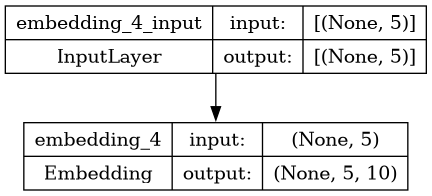

In [25]:
keras.utils.plot_model(embedding_model,show_shapes=True,show_layer_names=True)

# Contextual Embeddings:

* **ELMo (2018):** Uses bi-directional LSTMs to capture word meaning based on surrounding context.
* **BERT (2018):** Pre-trained transformer model on large unlabeled text, learning contextualized representations.
* **XLNet (2019):** Builds upon BERT's masked language modeling with permutation language modeling for better understanding of word relationships.

> <h2>Word Embeddings using Bert (Transformers)</h2>
The implementation of BERT (Bidirectional Encoder Representations from Transformers) for predicting word embeddings involves fine-tuning the pre-trained BERT model on a specific downstream task. Utilizing TensorFlow or PyTorch frameworks, the process typically entails loading the pre-trained BERT model, adding task-specific layers (such as classification layers for sentiment analysis or named entity recognition), and fine-tuning the entire model on a labeled dataset. During fine-tuning, the model's parameters are adjusted to optimize performance on the target task, enabling BERT to capture contextual word embeddings that reflect the nuances of the given task. Once trained, the fine-tuned BERT model can generate word embeddings that encode rich semantic information from the input text, facilitating enhanced performance on a wide range of natural language processing tasks.

In [26]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')


# Tokenize text
tokenized_texts = tokenizer(Docs, return_tensors='tf', padding=True, truncation=True, max_length=128)

# Obtain word embeddings
output = model(**tokenized_texts)

# Extract word embeddings
word_embeddings = output.last_hidden_state.numpy()

# Calculate mean word embeddings for each sentence
mean_word_embeddings = np.mean(word_embeddings, axis=1)

# Display mean word embeddings for each sentence
for i, mean_embedding in enumerate(mean_word_embeddings):
    print(f"Mean Word Embeddings for Sentence {i + 1}:")
    print(mean_embedding)
    print('----------')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Mean Word Embeddings for Sentence 1:
[-2.04305544e-01 -1.81919411e-01 -5.67251921e-01 -2.50381351e-01
  5.18146753e-02 -8.39289576e-02 -1.64983854e-01  5.50135255e-01
 -3.02776992e-01  1.82250217e-01  4.48545247e-01 -3.83128852e-01
 -1.01199031e-01  1.55241862e-01 -5.67098498e-01 -7.92788267e-02
  2.81859726e-01  1.31031290e-01 -4.40042168e-01  8.52410793e-02
  1.05671987e-01  2.95385808e-01 -2.56191939e-01  3.67899001e-01
  1.41279459e-01  1.56281084e-01 -2.50345856e-01  2.29516521e-01
  1.50050893e-01 -4.32114191e-02  2.49939829e-01 -2.33981505e-01
  3.00897267e-02 -1.76527396e-01 -2.66757905e-01  7.28176832e-02
 -1.68153152e-01  7.67113119e-02 -4.35148627e-01  1.76707461e-01
 -4.86129284e-01 -1.72617048e-01  7.87289590e-02  1.26926512e-01
 -5.82963414e-02 -2.12164506e-01  2.98652470e-01 -1.09550759e-01
  4.24578637e-01 -2.75301725e-01 -2.54252702e-01  4.35967930e-02
  6.24316670e-02 -1.11223631e-01  3.73741060e-01  7.75230050e-01
  3.12518418e-01 -2.19001502e-01 -3.67718413e-02 -2.1

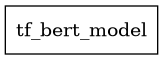

In [27]:
keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

# Summary & Future trends:

* **Count of Words (Bag-of-Words Model):**  Early NLP models represented documents using a Bag-of-Words (BoW) model, which counts the occurrence of words in a document without considering their order. This approach provides a basic representation of documents but lacks capturing semantic relationships.
* **Term Frequency-Inverse Document Frequency (TF-IDF):** introduced a weighting scheme that considers not only the count of words in a document but also their importance in the entire corpus. It helps identify words that are significant to a particular document but not frequent across all documents.
* **Latent Semantic Analysis (LSA):** also known as Latent Semantic Indexing (LSI), applies singular value decomposition (SVD) to the term-document matrix. It reduces the dimensionality of the space and captures latent semantic relationships between words and documents, improving representation.
* **Skip-gram and Continuous Bag of Words (CBOW):** Word2Vec, introduced by Mikolov et al., includes two models: Skip-gram and Continuous Bag of Words (CBOW). These models use shallow neural networks to learn word embeddings. Skip-gram predicts context words given a target word, while CBOW predicts a target word given its context. Word2Vec significantly improves word embeddings' quality and captures semantic relationships.
* **Global Vectors for Word Representation (GloVe):** introduces a global approach by training on aggregated global word co-occurrence statistics. It leverages a matrix factorization technique to capture the relationships between words in a more efficient manner, producing high-quality word embeddings.
* **FastText and Subword Embeddings:** also by Mikolov et al., extends word embeddings to subword level. It represents words as bags of character n-grams, enabling the generation of embeddings for out-of-vocabulary words and capturing morphological information.
* **Transformer Architecture:** introduced by Vaswani et al., revolutionizes NLP by employing self-attention mechanisms. It enables models like BERT (Bidirectional Encoder Representations from Transformers) to learn contextualized word embeddings, considering the entire input sequence bidirectionally.
* **Contextualized Word Embeddings (BERT, GPT, ELMo):** BERT, GPT (Generative Pre-trained Transformer), and ELMo (Embeddings from Language Models) introduce contextualized embeddings by considering surrounding words and contexts. These models capture rich contextual information, leading to state-of-the-art performance in various NLP tasks.
* **Transfer Learning and Fine-Tuning:** Pre-trained language models, such as BERT and GPT, can be fine-tuned on specific downstream tasks. This transfer learning approach significantly reduces the need for large labeled datasets and improves performance on specific tasks.
* **Multimodal Embeddings:** are extended beyond text to include multimodal information, combining textual and visual features. Models like CLIP (Contrastive Language-Image Pre-training) learn joint representations of text and images, enabling cross-modal understanding.


**Towards Understanding and Generation:**

* **GPT-3 (2020):** Generative Pre-trained Transformer 3, a large language model (LLM) with impressive text generation capabilities.
* **LaMDA (2021):** Language Model for Dialogue Applications, focuses on factual consistency and grounding in conversation.
* **PaLM (2022):** Pathways Language Model, pushes the boundaries of LLM size and performance, demonstrating progress in reasoning and question answering.

**Key breakpoints:**

* **From word counts to context:** Moving beyond simple frequency to considering surrounding words for richer representations.
* **Pre-training on large corpora:** Utilizing massive amounts of text data to learn general language understanding.
* **Bi-directional and attention mechanisms:** Capturing complex relationships between words in a sentence.
* **Transformers and self-attention:** Enabling efficient learning of long-range dependencies.
* **LLMs reaching human-level performance in certain tasks:** Highlighting the potential of language models for natural communication and problem-solving.


**Future directions:**

* **Explainability and interpretability:** Understanding how LLMs work and make decisions.
* **Addressing biases and fairness:** Ensuring models are inclusive and represent diverse perspectives.
* **Combining symbolic and neural approaches:** Integrating logic and reasoning with language understanding.
